# Project 3 : Collaborative Filtering

### Importing Libraries

In [2]:
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random 
random.seed(42)

from sklearn import metrics #, preprocessing

#!pip install surprise
import surprise
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise import AlgoBase
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.model_selection.split import KFold
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

In [2]:
# Read data:
ratings = pd.read_csv('ratings.csv')
movie_genres = pd.read_csv('movies.csv', names=['movieid', 'title', 'genres'], header=0)

## MovieLens data set
Questions 1-6

### Question 1: 
Compute the sparsity of the movie rating dataset, where sparsity is defined by:

$sparsity= \frac{AvailableRatings}{All Possible Ratings}$


In [3]:
num_rtrs   = len(np.unique(ratings.userId))
num_movies = len(np.unique(ratings.movieId))
num_rtngs  = len(ratings.rating)
num_poss_rtngs = np.multiply(num_rtrs,num_movies)
rtng_sparsity  = np.divide(num_rtngs,num_poss_rtngs)
print('Number of Raters:           ', num_rtrs)
print('Number of Movies:           ', num_movies)
print('Number of Movies Rated:     ', num_rtngs)
print('Number of Possible Ratings: ', num_poss_rtngs)
print('Sparisity of Ratings:        %0.10f' % rtng_sparsity)

Number of Raters:            610
Number of Movies:            9724
Number of Movies Rated:      100836
Number of Possible Ratings:  5931640
Sparisity of Ratings:        0.0169996831


### Question 2: 
Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

Potential ratings present in the dataset are:  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


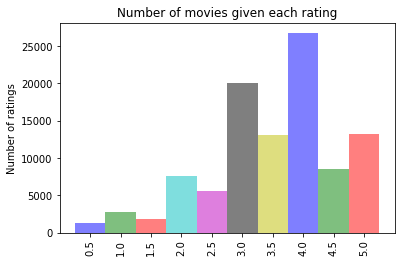

In [4]:
rate_labels = np.unique(ratings.rating)
print('Potential ratings present in the dataset are: ', rate_labels)
max_ratings = max(rate_labels)
min_ratings = min(rate_labels)
bin_width = 0.5
[freq_rtngs, _] = np.histogram(ratings.rating,
                                bins=np.arange(min_ratings,max_ratings+2*bin_width,bin_width))
cyc = cycle('bgrcmky')
for i in range(len(rate_labels)):
    plt.bar([rate_labels[i]], [freq_rtngs[i]], width=0.5,
           align='center', color=next(cyc),
           alpha=0.5, label=rate_labels[i])
plt.xticks(rate_labels, rate_labels, rotation=90)
plt.ylabel("Number of ratings")
plt.subplots_adjust(bottom= 0.22, top = 0.95)
plt.title('Number of movies given each rating')
plt.show()

### Question 3: 
Plot the distribution of the number of ratings received among movies. 
To be specific, the X-axis should be the movie index ordered by decreasing frequency 
and the Y-axis should be the number of ratings the movie has received. For example,
the movie that has the largest number of ratings has index 1; ties can broken in any way.
A monotonically decreasing curve instead of a histogram is expected

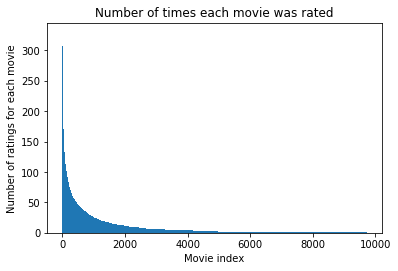

In [6]:
#Sort movies by number rated
movies_cntd  = ratings.groupby('movieId', sort=False).count().userId
movies_srted = movies_cntd.reset_index(name='count').sort_values(['count'], ascending=False) 
movies_srted = np.array(movies_srted)
movie_count  = movies_srted[:,1]
x_movie_count = np.arange(len(movie_count))

plt.bar(x_movie_count, movie_count, align='center', width=1)
plt.xlabel('Movie index')
plt.ylabel('Number of ratings for each movie')
plt.subplots_adjust(bottom= 0.22, top = 0.95)
plt.title("Number of times each movie was rated")
plt.show()

### Question 4:
Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y-axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3

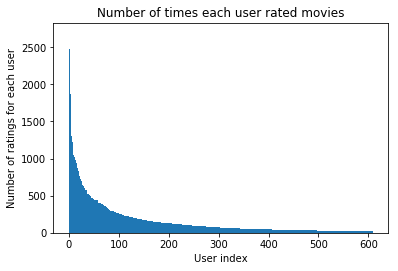

In [8]:
#Sort users by number rated
users_cntd  = ratings.groupby('userId', sort=False).count().movieId
users_srted = users_cntd.reset_index(name='count').sort_values(['count'], ascending=False) 
users_srted = np.array(users_srted)
user_count  = users_srted[:,1]
x_user_count = np.arange(len(user_count))
    
plt.bar(x_user_count, user_count, align='center', width=1)          
plt.xlabel('User index')
plt.ylabel('Number of ratings for each user')
plt.subplots_adjust(bottom= 0.22, top = 0.95)
plt.title("Number of times each user rated movies")
plt.show()

### Question 5:

The plot from question-3 shows that extremely few have a good number of ratings. ***Need to explain how it affects our recommendation process negatively !!!NEED TO BE READ!!!***

### Question 6: 
Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

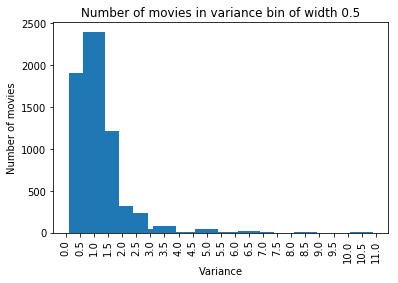

In [10]:
#Variance of each movie's ratings
movie_var  = ratings.groupby('movieId', sort=False).var().rating
movie_var = movie_var.dropna()
bin_width_var = 0.5
movie_var_min = min(movie_var)
movie_var_max = max(movie_var)

bins = np.arange(movie_var_min, movie_var_max+2*bin_width_var, bin_width_var)
dgtz_movie_var = np.digitize(movie_var, bins)
x_dgtz_mv_var_cntd, dgtz_mv_var_cntd  = np.unique(dgtz_movie_var, return_counts=True)
plt.bar(bins[x_dgtz_mv_var_cntd], dgtz_mv_var_cntd, align='center')          
        #label=users_srted[:,0])
plt.xticks(bins, rotation=90)
plt.xlabel('Variance')
plt.ylabel('Number of movies')
plt.subplots_adjust(bottom= 0.22, top = 0.95)
plt.title("Number of movies in variance bin of width 0.5")
plt.show()

# Question 7

$$\mu_u = \frac{\sum_{k} r_u_k}{\sum_{k} I_u_k}$$

# Question 8

- The movies that have been rated by both users "u" and user "v".
- Yes. If there is no movie that was rated by both users "u" and "v". 

# Question 9

- To eliminate the baseline "noise". Since some users are generous recommenders while others are tough recommenders, we subtract the mean to keep only the diffrential preference of the user to a certain movie compared with his preference to other movies. 

# Question 10

In [3]:
# Load the ml-latest-small ratings dataset  UserID::MovieID::Rating::Timestamp
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)
rating_data = Dataset.load_from_file('ratings.csv', reader=reader)

In [4]:
knn_RMSE_total=[]
knn_MAE_total=[]

K=np.arange(2,102,2)

for i in K:
    kn = KNNWithMeans(k=i, sim_options={'name': 'pearson_baseline', 'user_based': True})
    results = cross_validate(kn, rating_data, measures=['rmse', 'mae'], cv=10, verbose=True)
    knn_RMSE_total.append(np.mean(results['test_rmse']))
    knn_MAE_total.append(np.mean(results['test_mae']))
    print('\nk = %d\n' % i)
    print('-' * 50)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8827  0.8980  0.9053  0.9036  0.8952  0.9013  0.8887  0.8854  0.8892  0.8940  0.8944  0.0073  
MAE (testset)     0.6717  0.6841  0.6826  0.6745  0.6796  0.6820  0.6736  0.6695  0.6755  0.6778  0.6771  0.0047  
Fit time          1.20    1.24    1.18    1.21    1.24    1.19    1.17    1.26    1.24    1.19    1.21    0.03    
Test time         0.69    0.74    0.68 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8944  0.8925  0.8734  0.8998  0.8845  0.8834  0.8894  0.8835  0.8816  0.8975  0.8880  0.0078  
MAE (testset)     0.6727  0.6776  0.6644  0.6816  0.6698  0.6709  0.6745  0.6673  0.6689  0.6752  0.6723  0.0049  
Fit time          1.28    1.22    1.25    1.23    1.24    1.30    1.42    1.24    1.28    1.24    1.27    0.06    
Test time         0.95    0.96    0.99 

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9043  0.8893  0.8910  0.8787  0.8883  0.8916  0.8766  0.8848  0.8860  0.8780  0.8869  0.0078  
MAE (testset)     0.6890  0.6748  0.6760  0.6676  0.6746  0.6737  0.6619  0.6707  0.6724  0.6656  0.6726  0.0069  
Fit time          1.31    1.30    1.19    1.24    1.28    1.21    1.26    1.33    1.26    1.24    1.26    0.04    
Test time         0.97    1.07    1.06    1.20    1.10    1.07    1.01    0.98    1.10    1

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8913  0.8878  0.8983  0.8899  0.8884  0.8788  0.8845  0.8880  0.8793  0.8937  0.8880  0.0057  
MAE (testset)     0.6750  0.6715  0.6775  0.6783  0.6773  0.6695  0.6710  0.6752  0.6702  0.6715  0.6737  0.0032  
Fit time          1.20    1.26    1.25    1.29    1.31    1.25    1.27    1.27    1.26    1.29    1.26    0.03    
Test time         1.22    1.06    1.09    1.04    1.05    1.02    1.14    1.39    1.17    1

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8817  0.8835  0.8817  0.8984  0.8888  0.8909  0.8939  0.8908  0.8944  0.8815  0.8886  0.0058  
MAE (testset)     0.6658  0.6745  0.6749  0.6802  0.6764  0.6777  0.6772  0.6732  0.6731  0.6658  0.6739  0.0045  
Fit time          3.09    1.70    1.34    2.05    1.84    1.53    1.35    1.18    1.44    1.34    1.68    0.53    
Test time         1.38    1.46    1.30    1.48    1.67    1.80    1.10    1.09    1.78    1

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8858  0.8831  0.8853  0.8916  0.8848  0.8973  0.8861  0.8867  0.8891  0.8819  0.8872  0.0043  
MAE (testset)     0.6701  0.6683  0.6689  0.6759  0.6741  0.6806  0.6742  0.6725  0.6720  0.6670  0.6724  0.0039  
Fit time          1.53    1.39    1.24    1.31    1.28    1.21    1.29    1.29    1.30    1.26    1.31    0.09    
Test time         1.26    1.22    1.16    1.08    1.10    1.40    1.10    1.09    1.15    1

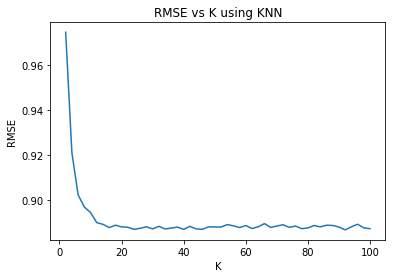

In [5]:
plt.plot(K,knn_RMSE_total)
plt.title('RMSE vs K using KNN')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

In [6]:
print('Min RMSE Val: ', min(knn_RMSE_total))

Min RMSE Val:  0.8866068337821016


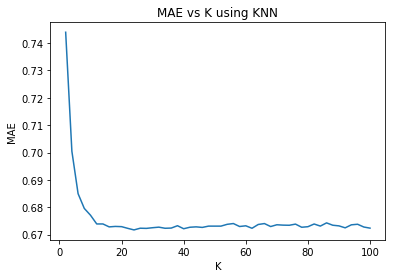

In [7]:
plt.plot(K, knn_MAE_total)
plt.title('MAE vs K using KNN')
plt.ylabel('MAE')
plt.xlabel('K')
plt.show()

# Question 11 : Optimum k

The optimal value of k is around 20.

In [9]:
# Split the complete data based on number of times it is watched
# userId,movieId,rating,timestamp
ratings_raw = rating_data.raw_ratings
Mov_rat_dic = {}
for item in ratings_raw:
    if item[1] not in Mov_rat_dic:
        Mov_rat_dic[item[1]] = []
    Mov_rat_dic[item[1]].append(item[2])

varience_dict = {}
for j in Mov_rat_dic:
    varience_dict[j] = np.var(Mov_rat_dic[j])
    
popul_trim_test_id=[]
popul_trim_test_id = [x for x in Mov_rat_dic if len(Mov_rat_dic[x]) > 2]
unpopul_trim_test_id=[]
unpopul_trim_test_id = [x for x in Mov_rat_dic if len(Mov_rat_dic[x]) < 3]
var_trim_test_id=[]
var_trim_test_id = [x for x in Mov_rat_dic if len(Mov_rat_dic[x]) > 4 and varience_dict[x] >= 2 ]

In [10]:
knn_cv_10 = KFold(n_splits=10, random_state=42)
knn_RMSE_total_pop = []
knn_RMSE_total_unpop = []
knn_RMSE_total_var = []

knn_K = np.arange(2, 102, 2)

for i in knn_K:
    knn_RMSE_avg=[]
    knn_model = KNNWithMeans(k=i, sim_options={'name': 'pearson', 'user_based': True})
    
    RMSE_pop = []
    RMSE_unpop = []
    RMSE_var = []
    
    for trainset, testset in knn_cv_10.split(rating_data):
        # Train and Validate 
        knn_model.fit(trainset)

        #Trim & Predict
        trimmed_testset_pop=[]
        trimmed_testset_pop = [x for x in testset if x[1] in popul_trim_test_id]
        predict_pop = knn_model.test(trimmed_testset_pop)
        
        trimmed_testset_unpop=[]
        trimmed_testset_unpop = [x for x in testset if x[1] in unpopul_trim_test_id]
        predict_unpop = knn_model.test(trimmed_testset_unpop)
        
        trimmed_testset_var=[]
        trimmed_testset_var = [x for x in testset if x[1] in var_trim_test_id]
        predict_var = knn_model.test(trimmed_testset_var)
        
        # Evaluate perfromance
        RMSE_pop.append(accuracy.rmse(predict_pop, verbose=True))
        RMSE_unpop.append(accuracy.rmse(predict_unpop, verbose=True))
        RMSE_var.append(accuracy.rmse(predict_var, verbose=True))
    
    knn_RMSE_total_pop.append(np.mean(RMSE_pop))
    knn_RMSE_total_unpop.append(np.mean(RMSE_unpop))
    knn_RMSE_total_var.append(np.mean(RMSE_var))

    print('\nk = %d\n' % i)
    print('-' * 50)        


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0321
RMSE: 1.1200
RMSE: 1.8394
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0027
RMSE: 1.1582
RMSE: 1.4236
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0079
RMSE: 1.0626
RMSE: 1.7533
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0120
RMSE: 1.1182
RMSE: 1.7471
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0197
RMSE: 1.1219
RMSE: 1.3510
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9936
RMSE: 1.1209
RMSE: 1.3396
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0078
RMSE: 1.1987
RMSE: 1.2160
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0141
RMSE: 1.0615
RMSE: 1.5964
Computing the pearson similarity matrix...
Done computing similarity mat

RMSE: 0.8771
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8806
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8906
RMSE: 1.0693
RMSE: 1.8036

k = 14

--------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8995
RMSE: 1.1200
RMSE: 1.6554
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8692
RMSE: 1.1582
RMSE: 1.3944
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8709
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8765
RMSE: 1.1182
RMSE: 1.7334
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8816
RMSE: 1.1219
RMSE: 1.3168
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8595

Done computing similarity matrix.
RMSE: 0.8566
RMSE: 1.1209
RMSE: 1.4142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8739
RMSE: 1.1987
RMSE: 1.2336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8706
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8749
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8863
RMSE: 1.0693
RMSE: 1.8036

k = 28

--------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8959
RMSE: 1.1200
RMSE: 1.6554
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8652
RMSE: 1.1582
RMSE: 1.3944
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8676
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computi

RMSE: 0.8673
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8733
RMSE: 1.1182
RMSE: 1.7334
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8763
RMSE: 1.1219
RMSE: 1.3168
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8566
RMSE: 1.1209
RMSE: 1.4142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8734
RMSE: 1.1987
RMSE: 1.2336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8698
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8742
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8861
RMSE: 1.0693
RMSE: 1.8036

k = 42

--------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8953

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8953
RMSE: 1.1200
RMSE: 1.6554
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8650
RMSE: 1.1582
RMSE: 1.3944
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8677
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8735
RMSE: 1.1182
RMSE: 1.7334
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8764
RMSE: 1.1219
RMSE: 1.3168
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8567
RMSE: 1.1209
RMSE: 1.4142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8739
RMSE: 1.1987
RMSE: 1.2336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8700
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity mat

RMSE: 0.8703
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8743
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8862
RMSE: 1.0693
RMSE: 1.8036

k = 68

--------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8954
RMSE: 1.1200
RMSE: 1.6554
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8651
RMSE: 1.1582
RMSE: 1.3944
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8680
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8738
RMSE: 1.1182
RMSE: 1.7334
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8763
RMSE: 1.1219
RMSE: 1.3168
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8567

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8569
RMSE: 1.1209
RMSE: 1.4142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8739
RMSE: 1.1987
RMSE: 1.2336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8707
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8744
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8866
RMSE: 1.0693
RMSE: 1.8036

k = 82

--------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8956
RMSE: 1.1200
RMSE: 1.6554
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8652
RMSE: 1.1582
RMSE: 1.3944
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8682
RMSE: 1.0626
RMSE: 1.7076
Computing th

Done computing similarity matrix.
RMSE: 0.8684
RMSE: 1.0626
RMSE: 1.7076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8744
RMSE: 1.1182
RMSE: 1.7334
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8766
RMSE: 1.1219
RMSE: 1.3168
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8570
RMSE: 1.1209
RMSE: 1.4142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8741
RMSE: 1.1987
RMSE: 1.2336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8708
RMSE: 1.0615
RMSE: 1.6011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8745
RMSE: 1.1281
RMSE: 1.7104
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8867
RMSE: 1.0693
RMSE: 1.8036

k = 96

--------------------------------------------------
Computing the pearson similarity matrix...
Done computi

# Question 12 : Popular movie trimmed test set


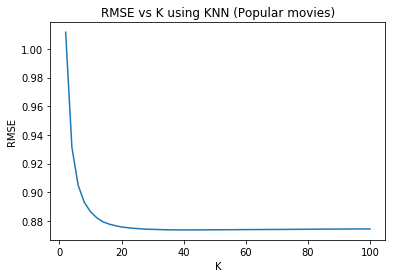

In [12]:
plt.plot(knn_K, knn_RMSE_total_pop)
plt.title('RMSE vs K using KNN (Popular movies)')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

In [11]:
print('Min RMSE Val: ', min(knn_RMSE_total_pop))
print ('Min RMSE Val at k =', knn_K[np.argmin(knn_RMSE_total_pop)])

Min RMSE Val:  0.8736912798366928
Min RMSE Val at k = 40


# Question 13 : Unpopular movie trimmed test set

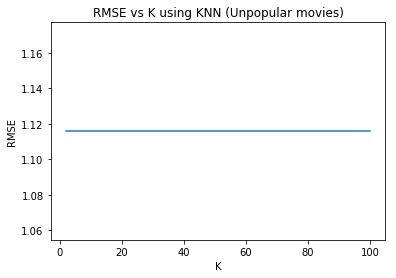

In [14]:
plt.plot(knn_K, knn_RMSE_total_unpop)
plt.title('RMSE vs K using KNN (Unpopular movies)')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

In [15]:
print('Min RMSE Val: ', min(knn_RMSE_total_unpop))
print ('Min RMSE Val at k =', knn_K[np.argmin(knn_RMSE_total_unpop)])

Min RMSE Val:  1.1159425221309174
Min RMSE Val at k = 2


# Question 14 : High varience movie trimmed test set

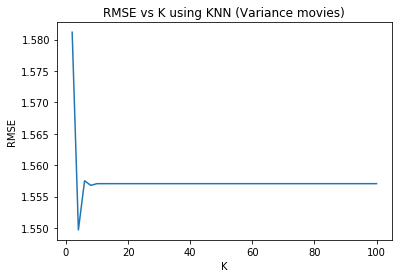

In [16]:
plt.plot(knn_K, knn_RMSE_total_var)
plt.title('RMSE vs K using KNN (Variance movies)')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

In [17]:
print('Min RMSE Val: ', min(knn_RMSE_total_var))
print ('Min RMSE Val at k =', knn_K[np.argmin(knn_RMSE_total_var)])

Min RMSE Val:  1.5496922875247594
Min RMSE Val at k = 4


### Question 15
Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the
curve (AUC) value.

In [20]:
k_best = 20
thrshld = [2.5, 3, 3.5, 4]
knn_fpr_all = []
knn_tpr_all = []
knn_roc_auc = [0,0,0,0]
count = 0

for i in thrshld:
    # split into train set and test set
    trainset, testset = train_test_split(rating_data, test_size=.1)

    # fit and test
    kn = KNNWithMeans(k=k_best, sim_options={'name': 'pearson_baseline', 'user_based': True})
    kn.fit(trainset)
    predictions = kn.test(testset)

    trues = [0 if getattr(row, 'r_ui') < i else 1 for row in predictions]
    scores = [getattr(row, 'est') for row in predictions]
    fpr, tpr, thresholds = metrics.roc_curve(trues, scores)
    knn_fpr_all.append(fpr)
    knn_tpr_all.append(tpr)
    knn_roc_auc[count]= metrics.auc(fpr, tpr)
    count += 1

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


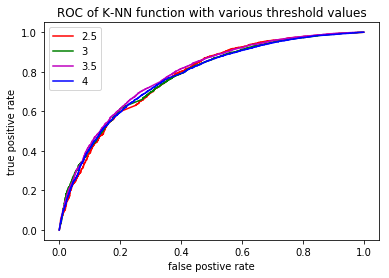

Area under ROC curve with threshold  2.5 :  0.7759298162433641
Area under ROC curve with threshold    3 :  0.7759439104841432
Area under ROC curve with threshold  3.5 :  0.7871718765474002
Area under ROC curve with threshold    4 :  0.7748473982426847


In [21]:
# plot roc curves:
plt.plot(knn_fpr_all[0], knn_tpr_all[0], 'r', label='2.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[0], roc_auc))
plt.plot(knn_fpr_all[1], knn_tpr_all[1], 'g', label='3')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(knn_fpr_all[2], knn_tpr_all[2], 'm', label='3.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(knn_fpr_all[3], knn_tpr_all[3], 'b', label='4')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))

plt.title('ROC of K-NN function with various threshold values')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

print('Area under ROC curve with threshold ', thrshld[0], ': ', knn_roc_auc[0])
print('Area under ROC curve with threshold   ', thrshld[1], ': ', knn_roc_auc[1])
print('Area under ROC curve with threshold ', thrshld[2], ': ', knn_roc_auc[2])
print('Area under ROC curve with threshold   ', thrshld[3], ': ', knn_roc_auc[3])

### Question 16

No equation 5 is not convex. **NEED TO EXPLAIN CLEARLY, EVEN I DONT UNDERSTAND EXACTLY** For U fixed it is clearly least squares.
**Need to write in detail in latex with equations**

### Question 17
Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter

In [ ]:
nmf_RMSE_total = []
nmf_MAE_total = []
K = np.arange(2,52,2)
for i in K:
    nmf_model = NMF(i, random_state=42)
    results = cross_validate(nmf_model, rating_data, measures=['rmse', 'mae'], cv=10, verbose=True)
    nmf_RMSE_total.append(np.mean(results['test_rmse']))
    nmf_MAE_total.append(np.mean(results['test_mae']))
    print('\nk = %d\n' % i)
    print('-' * 50)

Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1528  1.1420  1.1535  1.1468  1.1514  1.1429  1.1517  1.1474  1.1409  1.1570  1.1486  0.0052  
MAE (testset)     0.9691  0.9606  0.9673  0.9656  0.9704  0.9608  0.9696  0.9638  0.9583  0.9739  0.9659  0.0048  
Fit time          7.38    7.44    7.75    7.86    7.70    7.50    7.91    8.53    8.02    8.75    7.88    0.43    
Test time         0.12    0.12    0.12    0.11    0.11    0.11    0.11    0.11    0.12    0.13    0.12    0.01    

k = 2

--------------------------------------------------
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0357  1.0668  1.0354  1.0401  1.0496  1.0405  1.0467  1.0405  1.0480  1.0439  1.0447  0.0087  
MAE (testset)     0.8481  

In [33]:
plt.plot(K, nmf_RMSE_total)
plt.title('RMSE vs K using NMF')
plt.ylabel('RMSE')
plt.xlabel('k')
plt.show()

NameError: name 'nmf_RMSE_total' is not defined

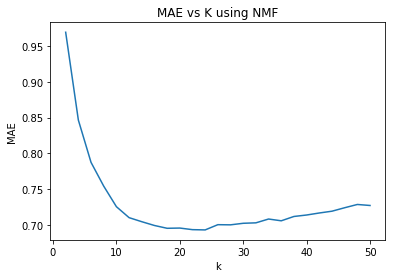

In [34]:
plt.plot(K, nmf_MAE_total)
plt.title('MAE vs K using NMF')
plt.ylabel('MAE')
plt.xlabel('k')
plt.show()

### Question 18
Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

In [35]:
print('Min RMSE Val: ', min(nmf_RMSE_total))
print ('Min RMSE Val at k =', K[np.argmin(nmf_RMSE_total)])

Min RMSE Val:  0.9131896585260326
Min RMSE Val at k = 18


In [36]:
print('Min MAE Val: ', min(nmf_MAE_total))
print ('Min MAE Val at k =', K[np.argmin(nmf_MAE_total)])

Min MAE Val:  0.6928517868207019
Min MAE Val at k = 24


#### Optimal number of latent factors: 18

Why difference??
The actual factors are 18.
EXPLAIN!!!

### Question 19
Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE.

In [32]:
nmf_cv_10 = KFold(n_splits=10, random_state=42, shuffle=True)
nmf_RMSE_total_pop=[]
nmf_RMSE_total_unpop=[]
nmf_RMSE_total_var=[]

nmf_K=np.arange(2,52,2)

for i in nmf_K:
    RMSE_pop=[]
    RMSE_unpop=[]
    RMSE_var=[]
    nmf_model = NMF(i, random_state=42)     
    for trainset, testset in nmf_cv_10.split(rating_data):
        # Train and Validate 
        nmf_model.fit(trainset)        
        #Trim & Predict
        trimmed_testset_pop=[]
        trimmed_testset_pop = [x for x in testset if x[1] in popul_trim_test_id]
        predict_pop = nmf_model.test(trimmed_testset_pop)
        trimmed_testset_unpop=[]
        trimmed_testset_unpop = [x for x in testset if x[1] in unpopul_trim_test_id]
        predict_unpop = nmf_model.test(trimmed_testset_unpop)
        trimmed_testset_var=[]
        trimmed_testset_var = [x for x in testset if x[1] in var_trim_test_id]
        predict_var = nmf_model.test(trimmed_testset_var)
        # Evaluate perfromance
        RMSE_pop.append(accuracy.rmse(predict_pop, verbose=True))
        RMSE_unpop.append(accuracy.rmse(predict_unpop, verbose=True))
        RMSE_var.append(accuracy.rmse(predict_var, verbose=True))    
    nmf_RMSE_total_pop.append(np.mean(RMSE_pop))
    nmf_RMSE_total_unpop.append(np.mean(RMSE_unpop))
    nmf_RMSE_total_var.append(np.mean(RMSE_var))
    print('\nk = %d\n' % i)
    print('-' * 50)

RMSE: 1.1426
RMSE: 1.2083
RMSE: 1.4128
RMSE: 1.1426
RMSE: 1.2584
RMSE: 1.5470
RMSE: 1.1336
RMSE: 1.2145
RMSE: 1.9217
RMSE: 1.1475
RMSE: 1.2624
RMSE: 1.7831
RMSE: 1.1428
RMSE: 1.2648
RMSE: 1.4983
RMSE: 1.1328
RMSE: 1.2528
RMSE: 1.5895
RMSE: 1.1256
RMSE: 1.3097
RMSE: 1.5936
RMSE: 1.1491
RMSE: 1.1898
RMSE: 2.0110
RMSE: 1.1473
RMSE: 1.2470
RMSE: 2.0031
RMSE: 1.1455
RMSE: 1.2659
RMSE: 1.9170

k = 2

--------------------------------------------------
RMSE: 1.0337
RMSE: 1.2067
RMSE: 1.4460
RMSE: 1.0338
RMSE: 1.2724
RMSE: 1.5406
RMSE: 1.0233
RMSE: 1.1949
RMSE: 1.7921
RMSE: 1.0364
RMSE: 1.2351
RMSE: 1.6671
RMSE: 1.0303
RMSE: 1.2641
RMSE: 1.5067
RMSE: 1.0185
RMSE: 1.2287
RMSE: 1.7329
RMSE: 1.0190
RMSE: 1.2760
RMSE: 1.4031
RMSE: 1.0315
RMSE: 1.1717
RMSE: 1.6848
RMSE: 1.0348
RMSE: 1.2345
RMSE: 1.8058
RMSE: 1.0359
RMSE: 1.2271
RMSE: 1.5401

k = 4

--------------------------------------------------
RMSE: 0.9728
RMSE: 1.1956
RMSE: 1.7267
RMSE: 0.9675
RMSE: 1.2310
RMSE: 1.7248
RMSE: 0.9555
RMSE: 1.162

RMSE: 0.9284
RMSE: 1.1744
RMSE: 1.7865
RMSE: 0.9282
RMSE: 1.2035
RMSE: 1.4035
RMSE: 0.9201
RMSE: 1.1859
RMSE: 1.5270
RMSE: 0.9276
RMSE: 1.2352
RMSE: 1.3292
RMSE: 0.9136
RMSE: 1.1267
RMSE: 1.7415
RMSE: 0.9293
RMSE: 1.1937
RMSE: 1.7471
RMSE: 0.9395
RMSE: 1.1739
RMSE: 1.9585

k = 38

--------------------------------------------------
RMSE: 0.9453
RMSE: 1.1623
RMSE: 1.7769
RMSE: 0.9338
RMSE: 1.2046
RMSE: 1.7140
RMSE: 0.9297
RMSE: 1.1318
RMSE: 1.7657
RMSE: 0.9358
RMSE: 1.1710
RMSE: 1.8982
RMSE: 0.9339
RMSE: 1.2009
RMSE: 1.3713
RMSE: 0.9232
RMSE: 1.1756
RMSE: 1.6043
RMSE: 0.9390
RMSE: 1.2361
RMSE: 1.3030
RMSE: 0.9201
RMSE: 1.1184
RMSE: 1.5913
RMSE: 0.9335
RMSE: 1.1804
RMSE: 1.6209
RMSE: 0.9468
RMSE: 1.1792
RMSE: 1.9093

k = 40

--------------------------------------------------
RMSE: 0.9531
RMSE: 1.1613
RMSE: 1.7811
RMSE: 0.9346
RMSE: 1.2093
RMSE: 1.6015
RMSE: 0.9262
RMSE: 1.1235
RMSE: 1.6837
RMSE: 0.9382
RMSE: 1.1777
RMSE: 1.8119
RMSE: 0.9386
RMSE: 1.2002
RMSE: 1.6308
RMSE: 0.9277
RMSE: 1.1

KeyboardInterrupt: 

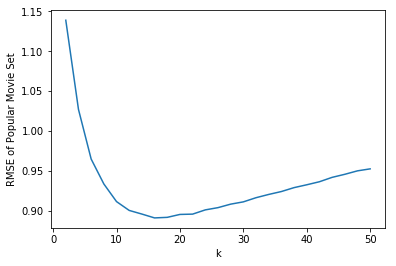

In [38]:
plt.plot(K, nmf_RMSE_total_pop)
plt.ylabel('RMSE of Popular Movie Set')
plt.xlabel('k')
plt.show()

In [39]:
print('Min RMSE Val of Popular Movie Set: ', min(nmf_RMSE_total_pop))
print ('Min RMSE Val at k =', nmf_K[np.argmin(nmf_RMSE_total_pop)])

Min RMSE Val of Popular Movie Set:  0.8909066810027401
Min RMSE Val at k = 16


### Question 20
Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

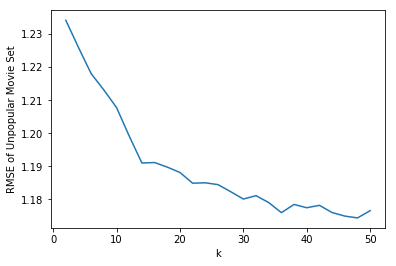

In [40]:
plt.plot(nmf_K, nmf_RMSE_total_unpop)
plt.ylabel('RMSE of Unpopular Movie Set')
plt.xlabel('k')
plt.show()

In [41]:
print('Min RMSE Val of Unpopular Movie Set: ', min(nmf_RMSE_total_unpop))
print ('Min RMSE Val at k =', nmf_K[np.argmin(nmf_RMSE_total_unpop)])

Min RMSE Val of Unpopular Movie Set:  1.1743888313895885
Min RMSE Val at k = 48


### Question 21
Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

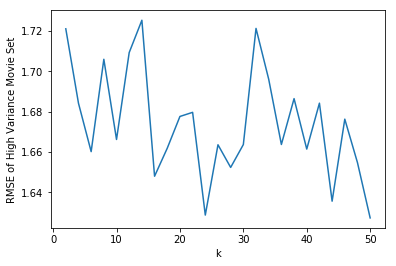

In [42]:
plt.plot(K, nmf_RMSE_total_var)
plt.ylabel('RMSE of High Variance Movie Set')
plt.xlabel('k')
plt.show()

In [43]:
print('Min RMSE Val of High Variance Movie Set: ', min(nmf_RMSE_total_var))
print ('Min RMSE Val at k =', nmf_K[np.argmin(nmf_RMSE_total_var)])

Min RMSE Val of High Variance Movie Set:  1.6273240430935387
Min RMSE Val at k = 50


### Question 22
Plot the ROC curves for the NNMF-based collaborative filter
designed in question 17 for threshold values [2.5, 3, 3.5, 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

In [36]:
k_nmf_best = 20
thrshld = [2.5, 3, 3.5, 4]
nmf_fpr_all = []
nmf_tpr_all = []
nmf_roc_auc = [0,0,0,0]
count = 0

# split into train set and test set
trainset, testset = train_test_split(rating_data, test_size=.1)

# fit and test
algo_nmf = NMF(k_nmf_best, random_state=42)
algo_nmf.fit(trainset)
predictions_nmf = algo_nmf.test(testset)

for i in thrshld:
    trues = [0 if getattr(row, 'r_ui') < i else 1 for row in predictions_nmf]
    scores = [getattr(row, 'est') for row in predictions_nmf]
    fpr, tpr, thresholds = metrics.roc_curve(trues, scores)
    nmf_fpr_all.append(fpr)
    nmf_tpr_all.append(tpr)
    nmf_roc_auc[count]= metrics.auc(fpr, tpr)
    count += 1

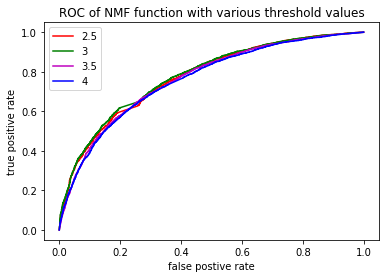

Area under ROC curve with threshold  2.5 :  0.7736772946077922
Area under ROC curve with threshold    3 :  0.7790914429701195
Area under ROC curve with threshold  3.5 :  0.7647201590470405
Area under ROC curve with threshold    4 :  0.7597167745274754


In [37]:
# plot roc curves:
plt.plot(nmf_fpr_all[0], nmf_tpr_all[0], 'r', label='2.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[0], roc_auc))
plt.plot(nmf_fpr_all[1], nmf_tpr_all[1], 'g', label='3')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(nmf_fpr_all[2], nmf_tpr_all[2], 'm', label='3.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(nmf_fpr_all[3], nmf_tpr_all[3], 'b', label='4')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))

plt.title('ROC of NMF function with various threshold values')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

print('Area under ROC curve with threshold ', thrshld[0], ': ', nmf_roc_auc[0])
print('Area under ROC curve with threshold   ', thrshld[1], ': ', nmf_roc_auc[1])
print('Area under ROC curve with threshold ', thrshld[2], ': ', nmf_roc_auc[2])
print('Area under ROC curve with threshold   ', thrshld[3], ': ', nmf_roc_auc[3])

### Question 23
Perform Non-negative matrix factorization on the ratings matrix
R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k
= 20). For each column of V , sort the movies in descending order and report
the genres of the top 10 movies. Do the top 10 movies belong to a particular
or a small collection of genre? Is there a connection between the latent factors
and the movie genres?

In [72]:
algo_nmf = NMF(k_nmf_best, random_state=42)
trainset = surprise.dataset.DatasetAutoFolds.build_full_trainset(rating_data)
algo_nmf.fit(trainset)
V = algo_nmf.qi

In [73]:
v_sorted = np.flip(np.sort(V[:, 0])[-10:], axis=0)
v_index = np.flip(np.argsort(V[:, 0])[-10:], axis=0)
for i in range(len(v_index)):
    print(movie_genres['genres'][v_index[i]])

Comedy
Drama
Action|Adventure|Thriller
Drama|Romance
Sci-Fi|Thriller
Comedy|Musical
Crime|Drama|Romance
Drama
Crime|Drama|Thriller
Drama


In [74]:
v_sorted = np.flip(np.sort(V[:, 1])[-10:], axis=0)
v_index = np.flip(np.argsort(V[:, 1])[-10:], axis=0)
for i in range(len(v_index)):
    print(movie_genres['genres'][v_index[i]])

Adventure|Animation|Drama|Fantasy|Sci-Fi
Comedy
Drama|Thriller|War
Adventure|Animation|Children|Fantasy
Action|Thriller
Action|War
Crime|Drama|Romance|Thriller
Drama
Drama
Comedy


##### MORE ANALYSIS NEEDED #####

Componenet-1 looks more like comedy, drama.

Component-2 looks more like Action.


##### MORE ANALYSIS NEEDED #####

### Question 24
Design a MF with bias collaborative filter to predict the ratings of
the movies in the MovieLens dataset and evaluate it’s performance using 10-fold
cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
of 2, and for each k compute the average RMSE and average MAE obtained
by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE
(Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.

In [49]:
svd_RMSE_total=[]
svd_MAE_total=[]

svd_K = np.arange(2,52,2)

for i in svd_K:
    algo_svd = SVD(i, random_state=42)
    results = cross_validate(algo_svd, rating_data, measures=['rmse', 'mae'], cv=10, verbose=True)
    svd_RMSE_total.append(np.mean(results['test_rmse']))
    svd_MAE_total.append(np.mean(results['test_mae']))
    print('\nk = %d\n' % i)
    print('-' * 50)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8582  0.8713  0.8738  0.8613  0.8701  0.8698  0.8712  0.8679  0.8657  0.8628  0.8672  0.0048  
MAE (testset)     0.6646  0.6679  0.6676  0.6624  0.6659  0.6638  0.6702  0.6686  0.6668  0.6667  0.6665  0.0022  
Fit time          1.34    1.38    1.38    1.36    1.52    1.33    1.34    1.46    1.32    1.42    1.38    0.06    
Test time         0.09    0.06    0.27    0.06    0.06    0.17    0.06    0.06    0.06    0.06    0.10    0.07    

k = 2

--------------------------------------------------
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8540  0.8735  0.8636  0.8753  0.8724  0.8635  0.8724  0.8660  0.8645  0.8600  0.8665  0.0065  
MAE (testset)     0.6561  

### Question 25
Use the plot from question 24, to find the optimal number of
latent factors. Optimal number of latent factors is the value of k that gives
the minimum average RMSE or the minimum average MAE. Please report the
minimum average RMSE and MAE.

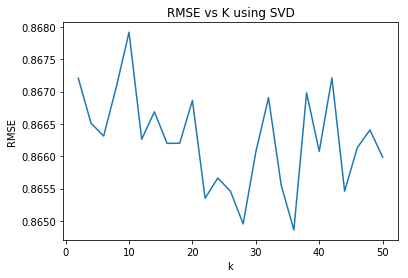

In [78]:
plt.plot(svd_K, svd_RMSE_total)
plt.title('RMSE vs K using SVD')
plt.ylabel('RMSE')
plt.xlabel('k')
plt.show()

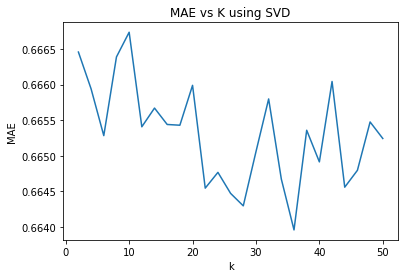

In [79]:
plt.plot(K, svd_MAE_total)
plt.title('MAE vs K using SVD')
plt.ylabel('MAE')
plt.xlabel('k')
plt.show()

In [75]:
print('Min RMSE Val: ', min(svd_RMSE_total))
print ('Min RMSE Val at k =', K[np.argmin(svd_RMSE_total)])

Min RMSE Val:  0.8648612328773213
Min RMSE Val at k = 36


In [81]:
print('Min MAE Val: ', min(svd_MAE_total))
print ('Min MAE Val at k =', K[np.argmin(svd_MAE_total)])

Min MAE Val:  0.6639582095966541
Min MAE Val at k = 36


### Question 26
Design a MF with bias collaborative filter to predict the ratings of
the movies in the popular movie trimmed test set and evaluate it’s performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to
50 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [54]:
svd_cv_10 = KFold(n_splits=10, random_state=42, shuffle=True)

svd_RMSE_total_pop = []
svd_RMSE_total_unpop = []
svd_RMSE_total_var = []

svd_K=np.arange(2, 52, 2)

for i in svd_K:
    RMSE_pop=[]
    RMSE_unpop=[]
    RMSE_var=[]
    algo_svd = SVD(i, random_state=42)
     
    for trainset, testset in svd_cv_10.split(rating_data):

        # Train and Validate 
        algo_svd.fit(trainset)
        
        #Trim & Predict
        trimmed_testset_pop=[]
        trimmed_testset_pop = [x for x in testset if x[1] in popul_trim_test_id]
        predict_pop = algo_svd.test(trimmed_testset_pop)
        
        trimmed_testset_unpop=[]
        trimmed_testset_unpop = [x for x in testset if x[1] in unpopul_trim_test_id]
        predict_unpop = algo_svd.test(trimmed_testset_unpop)
        
        trimmed_testset_var=[]
        trimmed_testset_var = [x for x in testset if x[1] in var_trim_test_id]
        predict_var = algo_svd.test(trimmed_testset_var)
        
        # Evaluate perfromance
        RMSE_pop.append(accuracy.rmse(predict_pop, verbose=True))
        RMSE_unpop.append(accuracy.rmse(predict_unpop, verbose=True))
        RMSE_var.append(accuracy.rmse(predict_var, verbose=True))
    
    svd_RMSE_total_pop.append(np.mean(RMSE_pop))
    svd_RMSE_total_unpop.append(np.mean(RMSE_unpop))
    svd_RMSE_total_var.append(np.mean(RMSE_var))

    print('\nk = %d\n' % i)
    print('-' * 50)

RMSE: 0.8774
RMSE: 0.9833
RMSE: 1.6491
RMSE: 0.8574
RMSE: 1.0324
RMSE: 1.5179
RMSE: 0.8512
RMSE: 0.9421
RMSE: 1.4192
RMSE: 0.8592
RMSE: 0.9725
RMSE: 1.6485
RMSE: 0.8599
RMSE: 0.9738
RMSE: 1.3541
RMSE: 0.8431
RMSE: 0.9576
RMSE: 1.3284
RMSE: 0.8621
RMSE: 1.0168
RMSE: 1.2611
RMSE: 0.8523
RMSE: 0.9273
RMSE: 1.5451
RMSE: 0.8616
RMSE: 0.9655
RMSE: 1.3926
RMSE: 0.8737
RMSE: 0.9706
RMSE: 1.6284

k = 2

--------------------------------------------------
RMSE: 0.8771
RMSE: 0.9846
RMSE: 1.6532
RMSE: 0.8562
RMSE: 1.0329
RMSE: 1.5102
RMSE: 0.8503
RMSE: 0.9434
RMSE: 1.3891
RMSE: 0.8588
RMSE: 0.9719
RMSE: 1.6435
RMSE: 0.8577
RMSE: 0.9736
RMSE: 1.3454
RMSE: 0.8417
RMSE: 0.9581
RMSE: 1.3250
RMSE: 0.8625
RMSE: 1.0174
RMSE: 1.2391
RMSE: 0.8516
RMSE: 0.9286
RMSE: 1.5357
RMSE: 0.8610
RMSE: 0.9654
RMSE: 1.3765
RMSE: 0.8735
RMSE: 0.9720
RMSE: 1.6345

k = 4

--------------------------------------------------
RMSE: 0.8778
RMSE: 0.9826
RMSE: 1.6530
RMSE: 0.8588
RMSE: 1.0306
RMSE: 1.5295
RMSE: 0.8517
RMSE: 0.942

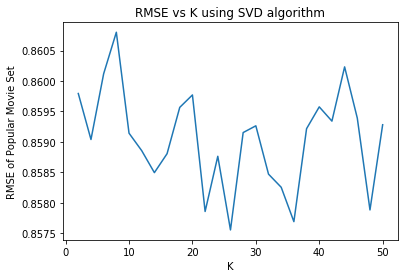

In [55]:
plt.plot(svd_K, svd_RMSE_total_pop)
plt.title('RMSE vs K using SVD algorithm')
plt.ylabel('RMSE of Popular Movie Set')
plt.xlabel('K')
plt.show()

In [56]:
print('Min RMSE Val of Popular Movie Set: ', min(svd_RMSE_total_pop))
print ('Min RMSE Val at k =', svd_K[np.argmin(svd_RMSE_total_pop)])

Min RMSE Val of Popular Movie Set:  0.8575553702721758
Min RMSE Val at k = 26


### Question 27

Design a MF with bias collaborative filter to predict the rat-
ings of the movies in the unpopular movie trimmed test set and evaluate it’s
performance using 10-fold cross validation. Sweep k (number of latent factors)
from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
against k (X-axis). Also, report the minimum average RMSE

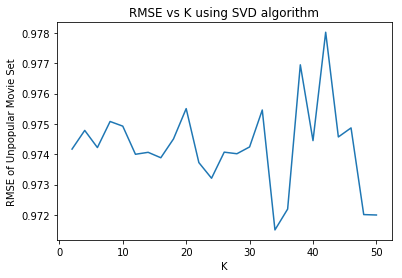

In [57]:
plt.plot(svd_K, svd_RMSE_total_unpop)
plt.title('RMSE vs K using SVD algorithm')
plt.ylabel('RMSE of Unpopular Movie Set')
plt.xlabel('K')
plt.show()

In [58]:
print('Min RMSE Val of Popular Movie Set: ', min(svd_RMSE_total_unpop))
print ('Min RMSE Val at k =', svd_K[np.argmin(svd_RMSE_total_unpop)])

Min RMSE Val of Popular Movie Set:  0.9715085605702845
Min RMSE Val at k = 34


### Question 28

Design a MF with bias collaborative filter to predict the rat-
ings of the movies in the high variance movie trimmed test set and evaluate it’s
performance using 10-fold cross validation. Sweep k (number of latent factors)
from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
against k (X-axis). Also, report the minimum average RMSE

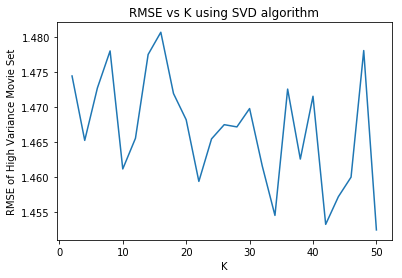

In [59]:
plt.plot(svd_K,svd_RMSE_total_var)
plt.title('RMSE vs K using SVD algorithm')
plt.ylabel('RMSE of High Variance Movie Set')
plt.xlabel('K')
plt.show()

In [60]:
print('Min RMSE Val of Popular Movie Set: ', min(svd_RMSE_total_var))
print ('Min RMSE Val at k =', svd_K[np.argmin(svd_RMSE_total_var)])

Min RMSE Val of Popular Movie Set:  1.452402855604463
Min RMSE Val at k = 50


### Question 29
Plot the ROC curves for the MF with bias collaborative filter
designed in question 24 for threshold values [2.5, 3, 3.5, 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 25. For each of
the plots, also report the area under the curve (AUC) value.

In [84]:
k_svd_best = 36 # Need a systematic way to get at this!!!
thrshld = [2.5, 3, 3.5, 4]
svd_fpr_all = []
svd_tpr_all = []
svd_roc_auc = [0,0,0,0]
count = 0

# split into train set and test set
trainset, testset = train_test_split(rating_data, test_size=.1)

# fit and test
algo_svd = SVD(k_svd_best)
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)

for i in thrshld:
    trues = [0 if getattr(row, 'r_ui') < i else 1 for row in predictions_svd]
    scores = [getattr(row, 'est') for row in predictions_svd]
    fpr, tpr, thresholds = metrics.roc_curve(trues, scores)
    svd_fpr_all.append(fpr)
    svd_tpr_all.append(tpr)
    svd_roc_auc[count]= metrics.auc(fpr, tpr)
    count += 1

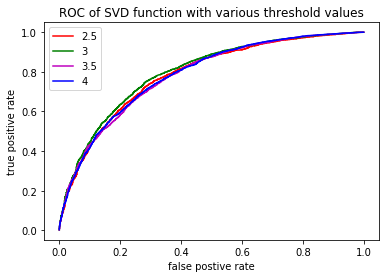

Area under ROC curve with threshold  2.5 :  0.7851991154398661
Area under ROC curve with threshold    3 :  0.7983001171018338
Area under ROC curve with threshold  3.5 :  0.7832907910185243
Area under ROC curve with threshold    4 :  0.7853134759393542


In [85]:
# plot roc curves:
plt.plot(svd_fpr_all[0], svd_tpr_all[0], 'r', label='2.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[0], roc_auc))
plt.plot(svd_fpr_all[1], svd_tpr_all[1], 'g', label='3')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(svd_fpr_all[2], svd_tpr_all[2], 'm', label='3.5')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(svd_fpr_all[3], svd_tpr_all[3], 'b', label='4')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))

plt.title('ROC of SVD function with various threshold values')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

print('Area under ROC curve with threshold ', thrshld[0], ': ', svd_roc_auc[0])
print('Area under ROC curve with threshold   ', thrshld[1], ': ', svd_roc_auc[1])
print('Area under ROC curve with threshold ', thrshld[2], ': ', svd_roc_auc[2])
print('Area under ROC curve with threshold   ', thrshld[3], ': ', svd_roc_auc[3])

### Question 30

Design a naive collaborative filter to predict the ratings of the
movies in the MovieLens dataset and evaluate it’s performance using 10-fold
cross validation. Compute the average RMSE by averaging the RMSE across
all 10 folds. Report the average RMSE.
Note that in this case, when performing the cross-validation, there is no need to
calculate μ i ’s for the training folds each time. You are only asked to use a sin-
gle set of μ i ’s calculated on the entire dataset and validate on 10 validation folds.

In [63]:
class NaiveCollab(AlgoBase):

    def __init__(self):
        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def estimate(self, u, i): # user_id, item_id, we just take user's mean
        mean = np.mean([r for (_, r) in self.trainset.ur[u]])
        return mean

In [64]:
naive_RMSE_total=[]
naive_MAE_total=[]

naive_algo = NaiveCollab()
naive_K = np.arange(2,52,2)
    
for i in naive_K:
    results = cross_validate(naive_algo, rating_data, measures=['rmse', 'mae'], cv=10, verbose=True)
    naive_RMSE_total.append(np.mean(results['test_rmse']))
    naive_MAE_total.append(np.mean(results['test_mae']))
    print('\nk = %d\n' % i)
    print('-' * 50)

Evaluating RMSE, MAE of algorithm NaiveCollab on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9456  0.9373  0.9357  0.9421  0.9406  0.9321  0.9491  0.9449  0.9403  0.9437  0.9411  0.0048  
MAE (testset)     0.7358  0.7297  0.7320  0.7319  0.7326  0.7301  0.7414  0.7333  0.7332  0.7378  0.7338  0.0034  
Fit time          0.00    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.01    
Test time         0.78    0.80    0.81    0.80    0.80    0.79    0.81    0.91    0.79    0.80    0.81    0.03    

k = 2

--------------------------------------------------
Evaluating RMSE, MAE of algorithm NaiveCollab on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9315  0.9493  0.9446  0.9378  0.9437  0.9398  0.9444  0.9408  0.9385  0.9399  0.9410  0.0046  
MAE (tests

### Question 31
Design a naive collaborative filter to predict the ratings of the
movies in the popular movie trimmed test set and evaluate it’s performance
using 10-fold cross validation. Compute the average RMSE by averaging the
RMSE across all 10 folds. Report the average RMSE.

In [65]:
naive_svd_10 = KFold(n_splits=10, random_state=42, shuffle=True)

naive_RMSE_total_pop=[]
naive_RMSE_total_unpop=[]
naive_RMSE_total_var=[]
naive_algo = NaiveCollab()

for trainset, testset in naive_svd_10.split(rating_data):
    # Train and Validate 
    naive_algo.fit(trainset)
    #Trim & Predict
    trimmed_testset_pop=[]
    trimmed_testset_pop = [x for x in testset if x[1] in popul_trim_test_id]
    predict_pop = naive_algo.test(trimmed_testset_pop)
    trimmed_testset_unpop=[]
    trimmed_testset_unpop = [x for x in testset if x[1] in unpopul_trim_test_id]
    predict_unpop = naive_algo.test(trimmed_testset_unpop)
    trimmed_testset_var=[]
    trimmed_testset_var = [x for x in testset if x[1] in var_trim_test_id]
    predict_var = naive_algo.test(trimmed_testset_var)
    # Evaluate perfromance
    naive_RMSE_total_pop.append(accuracy.rmse(predict_pop, verbose=True))
    naive_RMSE_total_unpop.append(accuracy.rmse(predict_unpop, verbose=True))
    naive_RMSE_total_var.append(accuracy.rmse(predict_var, verbose=True))

RMSE: 0.9544
RMSE: 0.9859
RMSE: 1.7950
RMSE: 0.9350
RMSE: 1.0381
RMSE: 1.5839
RMSE: 0.9361
RMSE: 0.9512
RMSE: 1.4440
RMSE: 0.9324
RMSE: 0.9725
RMSE: 1.6676
RMSE: 0.9389
RMSE: 0.9715
RMSE: 1.2817
RMSE: 0.9223
RMSE: 0.9507
RMSE: 1.3427
RMSE: 0.9466
RMSE: 1.0198
RMSE: 1.2481
RMSE: 0.9364
RMSE: 0.9276
RMSE: 1.4207
RMSE: 0.9364
RMSE: 0.9648
RMSE: 1.2022
RMSE: 0.9494
RMSE: 0.9679
RMSE: 1.6346


In [66]:
print('RMSE of Popular Movie Set: ' + str(np.mean(naive_RMSE_total_pop)))

RMSE of Popular Movie Set: 0.9388000618890873


### Question 32
Design a naive collaborative filter to predict the ratings of the
movies in the unpopular movie trimmed test set and evaluate it’s performance
using 10-fold cross validation. Compute the average RMSE by averaging the
RMSE across all 10 folds. Report the average RMSE.

In [67]:
print('RMSE of Unpopular Movie Set: ' + str(np.mean(naive_RMSE_total_unpop)))

RMSE of Unpopular Movie Set: 0.975014672263536


### Question 33
Design a naive collaborative filter to predict the ratings of the
movies in the high variance movie trimmed test set and evaluate it’s perfor-
mance using 10-fold cross validation. Compute the average RMSE by averaging
the RMSE across all 10 folds. Report the average RMSE

In [68]:
print('RMSE of High variance Movie Set: ' + str(np.mean(naive_RMSE_total_var)))

RMSE of High variance Movie Set: 1.462045219227838


### Question 34
Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and
MF with bias based collaborative filters in the same figure. Use the figure to
compare the performance of the filters in predicting the ratings of the movies.

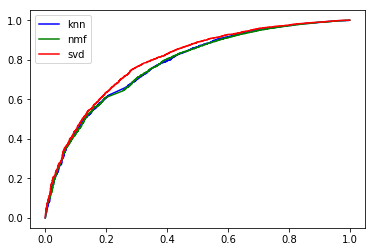

In [88]:
plt.plot(knn_fpr_all[1], knn_tpr_all[1], 'b', label='knn')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(nmf_fpr_all[1], nmf_tpr_all[1], 'g', label='nmf')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.plot(svd_fpr_all[1], svd_tpr_all[1], 'r', label='svd')#, label='K-NN θ=%.1f (area = %0.2f)' % (thrshld[1], roc_auc))
plt.legend()
plt.show()

#### NEED MORE ANAYLSIS ###

SVD seems to be on the top.(Kind of makes sense as they told NMF more suitable for interpretation).
KNN is generally weak.

#### NEED MORE ANAYLSIS ###

### Question 36

In [5]:
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)
rating_data = Dataset.load_from_file('ratings.csv', reader=reader)

In [6]:
# Create cross validation thing
CV1= KFold(n_splits=10, random_state=42, shuffle=True)

#swap model for Q 36,37,38
# Create collaborative filtering model
KNN_k = 20
model1= KNNBasic(k=KNN_k, sim_options={'name': 'pearson', 'user_based': True})
threshold=3

# Initialize fold averages
prec_fold_avg=[]
rec_fold_avg=[]

fold_number=1
#cross-val with 10 folds
for trainset, testset in CV1.split(rating_data):

    # Train and Validate 
    model1.fit(trainset) 

    # Predict      
    predictions = model1.test(testset)
    # Get list of users 
    uid=np.asarray([item.uid for item in predictions]) 
    # Find unqiue list of users & their locations within the predictions list
    users,idxs=np.unique(uid,return_index=True)

    # Initialize user precision and recall lists
    prec_usr=[]
    rec_usr=[]
    # Initialize counts for averaging over uneven lists
    counts =np.zeros(25)
    master_counts = counts
    for idx in idxs: 
        # For each user in the fold...
        user=uid[idx] 
        # Get all of this user's ground truth ratings
        rat=np.asarray([item.r_ui for item in predictions if item.uid==user])
        # Get our corresponding estimates of their ratings
        pred=np.asarray([item.est for item in predictions if item.uid==user]) 
        # Sort our estimates in descending order (get indices)...
        idx_sort=np.argsort(-1.0*pred)
        # And binarize for final Ground Truth G and Predicted Ratings L
        G=rat[idx_sort]>3
        L=pred[idx_sort]>3
        # Loop max is t=25 or length of Ground Truth G
        t_max=25 if rat.shape[0]>=25 else rat.shape[0]
        # Store "counts" for averaging over uneven lists
        counts[0:t_max]+=np.ones((t_max))
        # Keep top t_max rating to recommend
        G_top=G[0:t_max]
        L_top=L[0:t_max]
        # Get intersection of correct predictions and ground truth
        G_CAP_L = np.logical_not(np.logical_xor(G_top,L_top))
        # Numerator is a list of the # of correct predictions where the index=t
        numer = np.cumsum(G_CAP_L.astype(int))
        # Denominator for precision is t
        denom_p = np.arange(0,t_max)+1
        # Denominator for recall is always t_max
        denom_r = np.ones(t_max)*t_max
        # Get Recall and Precision lists for this user
        # Pad zeros for summations and averaging with even list length
        precisions=np.zeros(25)
        recalls=np.zeros(25)
        precisions[0:t_max]= np.divide(numer,denom_p)
        recalls[0:t_max] = np.divide(numer,denom_r)
        # Get user averages
        prec_usr.append([precisions])
        rec_usr.append([recalls])
        
    # Get fold averages, keeping list along t #CHECK AXISES
    # Potential issue, different sized arrays for different t_max won't avg along axes
    prec_avg_temp=np.divide(np.sum(prec_usr,axis=0),counts)
    prec_fold_avg.append([prec_avg_temp])
    rec_avg_temp=np.divide(np.sum(rec_usr,axis=0),counts)
    rec_fold_avg.append([rec_avg_temp])   
    master_counts+=counts
    print('fold number ', fold_number)
    fold_number+=1
    print('prec_fold_avg size=',prec_avg_temp)
    print('rec_fold_avg size=',rec_avg_temp.shape)
    print('------------------------------------')
    
# Get overall average precision and recall, keeping list along t #CHECK AXISES
prec_avg=np.divide(np.sum(prec_fold_avg,axis=0),np.ones(25)*10)
rec_avg=np.divide(np.sum(rec_fold_avg,axis=0),np.ones(25)*10)
      
print('------------------------------------')
print()
print('final averages:')
print('prec_avg=',prec_avg)
print('rec_avg=',rec_avg)



nmf_prec=np.squeeze(prec_avg)
nmf_rec=np.squeeze(rec_avg)



Computing the pearson similarity matrix...
Done computing similarity matrix.
fold number  1
prec_fold_avg size= [[0.76451078 0.76943463 0.74547804 0.75612472 0.75588235 0.75555556
  0.75884666 0.76121262 0.76409018 0.76626984 0.76379176 0.75771605
  0.75082812 0.74607143 0.74480287 0.74822443 0.75124026 0.75492264
  0.75103878 0.7465035  0.74417796 0.73643411 0.73987365 0.73660714
  0.72859813]]
rec_fold_avg size= (1, 25)
------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
fold number  2
prec_fold_avg size= [[0.80199667 0.78546099 0.78710938 0.77710177 0.77294686 0.76313406
  0.77256792 0.77338435 0.7724081  0.77420635 0.77713847 0.77245053
  0.77262443 0.77128053 0.76410256 0.75794798 0.75998548 0.76547353
  0.76612305 0.75905797 0.75829726 0.75672727 0.75755343 0.75967262
  0.7611215 ]]
rec_fold_avg size= (1, 25)
------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matri

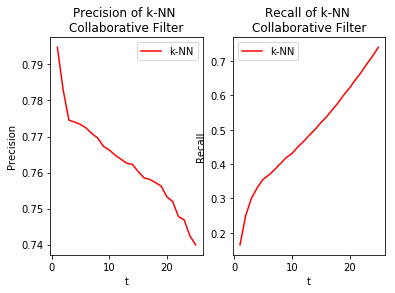

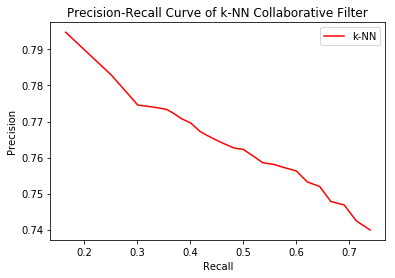

In [14]:
plt.subplot(1,2,1)
plt.plot(np.arange(1,26), nmf_prec, 'r', label='k-NN')
plt.title('Precision of k-NN \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,26), nmf_rec, 'r', label='k-NN')
plt.title('Recall of k-NN \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(nmf_rec, nmf_prec, 'r', label='k-NN')
plt.title('Precision-Recall Curve of k-NN Collaborative Filter')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### QUESTION 37

In [17]:
# Create cross validation thing
CV1= KFold(n_splits=10, random_state=42, shuffle=True)

#swap model for Q 36,37,38 UPDATE THIS
# Create collaborative filtering model
k_nmf_best = 18
model1= NMF(k_nmf_best, random_state=42)
threshold=3

# Initialize fold averages
prec_fold_avg=[]
rec_fold_avg=[]

fold_number=1
#cross-val with 10 folds
for trainset, testset in CV1.split(rating_data):

    # Train and Validate 
    model1.fit(trainset) 

    # Predict      
    predictions = model1.test(testset)
    # Get list of users 
    uid=np.asarray([item.uid for item in predictions]) 
    # Find unqiue list of users & their locations within the predictions list
    users,idxs=np.unique(uid,return_index=True)

    # Initialize user precision and recall lists
    prec_usr=[]
    rec_usr=[]
    # Initialize counts for averaging over uneven lists
    counts =np.zeros(25)
    master_counts = counts
    for idx in idxs: 
        # For each user in the fold...
        user=uid[idx] 
        # Get all of this user's ground truth ratings
        rat=np.asarray([item.r_ui for item in predictions if item.uid==user])
        # Get our corresponding estimates of their ratings
        pred=np.asarray([item.est for item in predictions if item.uid==user]) 
        # Sort our estimates in descending order (get indices)...
        idx_sort=np.argsort(-1.0*pred)
        # And binarize for final Ground Truth G and Predicted Ratings L
        G=rat[idx_sort]>3
        L=pred[idx_sort]>3
        # Loop max is t=25 or length of Ground Truth G
        t_max=25 if rat.shape[0]>=25 else rat.shape[0]
        # Store "counts" for averaging over uneven lists
        counts[0:t_max]+=np.ones((t_max))
        # Keep top t_max rating to recommend
        G_top=G[0:t_max]
        L_top=L[0:t_max]
        # Get intersection of correct predictions and ground truth
        G_CAP_L = np.logical_not(np.logical_xor(G_top,L_top))
        # Numerator is a list of the # of correct predictions where the index=t
        numer = np.cumsum(G_CAP_L.astype(int))
        # Denominator for precision is t
        denom_p = np.arange(0,t_max)+1
        # Denominator for recall is always t_max
        denom_r = np.ones(t_max)*t_max
        # Get Recall and Precision lists for this user
        # Pad zeros for summations and averaging with even list length
        precisions=np.zeros(25)
        recalls=np.zeros(25)
        precisions[0:t_max]= np.divide(numer,denom_p)
        recalls[0:t_max] = np.divide(numer,denom_r)
        # Get user averages
        prec_usr.append([precisions])
        rec_usr.append([recalls])
        
    # Get fold averages, keeping list along t #CHECK AXISES
    # Potential issue, different sized arrays for different t_max won't avg along axes
    prec_avg_temp=np.divide(np.sum(prec_usr,axis=0),counts)
    prec_fold_avg.append([prec_avg_temp])
    rec_avg_temp=np.divide(np.sum(rec_usr,axis=0),counts)
    rec_fold_avg.append([rec_avg_temp])   
    master_counts+=counts
    print('fold number ', fold_number)
    fold_number+=1
    print('prec_fold_avg size=',prec_avg_temp)
    print('rec_fold_avg size=',rec_avg_temp.shape)
    print('------------------------------------')
    
# Get overall average precision and recall, keeping list along t #CHECK AXISES
prec_avg=np.divide(np.sum(prec_fold_avg,axis=0),np.ones(25)*10)
rec_avg=np.divide(np.sum(rec_fold_avg,axis=0),np.ones(25)*10)
      
print('------------------------------------')
print()
print('final averages:')
print('prec_avg=',prec_avg)
print('rec_avg=',rec_avg)



nnmf_prec=np.squeeze(prec_avg)
nnmf_rec=np.squeeze(rec_avg)



fold number  1
prec_fold_avg size= [[0.77446103 0.75530035 0.75064599 0.75501114 0.75784314 0.75462963
  0.75535168 0.75332226 0.75402576 0.75595238 0.75796426 0.75192901
  0.75598086 0.74928571 0.75412186 0.75426136 0.75584692 0.7559775
  0.75588643 0.75314685 0.75286757 0.74630021 0.74842066 0.75037202
  0.74616822]]
rec_fold_avg size= (1, 25)
------------------------------------
fold number  2
prec_fold_avg size= [[0.78535774 0.77304965 0.76302083 0.76548673 0.76086957 0.75860507
  0.76468011 0.77380952 0.77116894 0.76904762 0.76716532 0.77054795
  0.7658371  0.76535899 0.76227106 0.75975434 0.76252723 0.76621924
  0.76575241 0.76050725 0.76046176 0.75527273 0.75829035 0.75818452
  0.76074766]]
rec_fold_avg size= (1, 25)
------------------------------------
fold number  3
prec_fold_avg size= [[0.76400679 0.77454545 0.76753507 0.76193182 0.75656566 0.75403609
  0.75471698 0.75       0.75010028 0.75       0.75628627 0.7484639
  0.74913027 0.75038402 0.75318352 0.75591716 0.75138735 0.

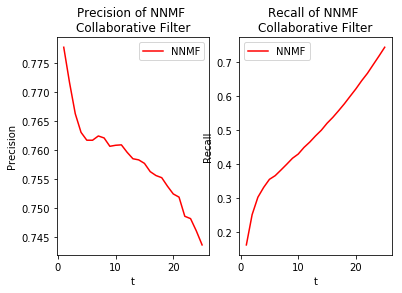

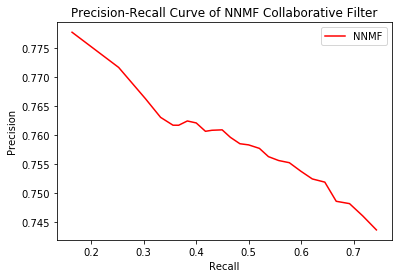

In [20]:
plt.subplot(1,2,1)
plt.plot(np.arange(1,26), nnmf_prec, 'r', label='NNMF')
plt.title('Precision of NNMF \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,26), nnmf_rec, 'r', label='NNMF')
plt.title('Recall of NNMF \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(nnmf_rec, nnmf_prec, 'r', label='NNMF')
plt.title('Precision-Recall Curve of NNMF Collaborative Filter')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### QUESTION 38

In [20]:
# Create cross validation thing
CV1= KFold(n_splits=10, random_state=42, shuffle=True)

#swap model for Q 36,37,38 UPDATE THIS
# Create collaborative filtering model
k_svd_best = 36
model1= SVD(k_svd_best, random_state=42)
threshold=3

# Initialize fold averages
prec_fold_avg=[]
rec_fold_avg=[]

fold_number=1
#cross-val with 10 folds
for trainset, testset in CV1.split(rating_data):

    # Train and Validate 
    model1.fit(trainset) 

    # Predict      
    predictions = model1.test(testset)
    # Get list of users 
    uid=np.asarray([item.uid for item in predictions]) 
    # Find unqiue list of users & their locations within the predictions list
    users,idxs=np.unique(uid,return_index=True)

    # Initialize user precision and recall lists
    prec_usr=[]
    rec_usr=[]
    # Initialize counts for averaging over uneven lists
    counts =np.zeros(25)
    master_counts = counts
    for idx in idxs: 
        # For each user in the fold...
        user=uid[idx] 
        # Get all of this user's ground truth ratings
        rat=np.asarray([item.r_ui for item in predictions if item.uid==user])
        # Get our corresponding estimates of their ratings
        pred=np.asarray([item.est for item in predictions if item.uid==user]) 
        # Sort our estimates in descending order (get indices)...
        idx_sort=np.argsort(-1.0*pred)
        # And binarize for final Ground Truth G and Predicted Ratings L
        G=rat[idx_sort]>3
        L=pred[idx_sort]>3
        # Loop max is t=25 or length of Ground Truth G
        t_max=25 if rat.shape[0]>=25 else rat.shape[0]
        # Store "counts" for averaging over uneven lists
        counts[0:t_max]+=np.ones((t_max))
        # Keep top t_max rating to recommend
        G_top=G[0:t_max]
        L_top=L[0:t_max]
        # Get intersection of correct predictions and ground truth
        G_CAP_L = np.logical_not(np.logical_xor(G_top,L_top))
        # Numerator is a list of the # of correct predictions where the index=t
        numer = np.cumsum(G_CAP_L.astype(int))
        # Denominator for precision is t
        denom_p = np.arange(0,t_max)+1
        # Denominator for recall is always t_max
        denom_r = np.ones(t_max)*t_max
        # Get Recall and Precision lists for this user
        # Pad zeros for summations and averaging with even list length
        precisions=np.zeros(25)
        recalls=np.zeros(25)
        precisions[0:t_max]= np.divide(numer,denom_p)
        recalls[0:t_max] = np.divide(numer,denom_r)
        # Get user averages
        prec_usr.append([precisions])
        rec_usr.append([recalls])
        
    # Get fold averages, keeping list along t #CHECK AXISES
    # Potential issue, different sized arrays for different t_max won't avg along axes
    prec_avg_temp=np.divide(np.sum(prec_usr,axis=0),counts)
    prec_fold_avg.append([prec_avg_temp])
    rec_avg_temp=np.divide(np.sum(rec_usr,axis=0),counts)
    rec_fold_avg.append([rec_avg_temp])   
    master_counts+=counts
    print('fold number ', fold_number)
    fold_number+=1
    print('prec_fold_avg size=',prec_avg_temp)
    print('rec_fold_avg size=',rec_avg_temp.shape)
    print('------------------------------------')
    
# Get overall average precision and recall, keeping list along t #CHECK AXISES
prec_avg=np.divide(np.sum(prec_fold_avg,axis=0),np.ones(25)*10)
rec_avg=np.divide(np.sum(rec_fold_avg,axis=0),np.ones(25)*10)
      
print('------------------------------------')
print()
print('final averages:')
print('prec_avg=',prec_avg)
print('rec_avg=',rec_avg)



mf_prec=np.squeeze(prec_avg)
mf_rec=np.squeeze(rec_avg)



fold number  1
prec_fold_avg size= [[0.78606965 0.76766784 0.7622739  0.76726058 0.77696078 0.77638889
  0.77981651 0.78031561 0.78099839 0.78134921 0.78399378 0.7808642
  0.78064041 0.77464286 0.7734767  0.77556818 0.775691   0.77637131
  0.77562327 0.77657343 0.77372263 0.76990839 0.77257525 0.76785714
  0.76411215]]
rec_fold_avg size= (1, 25)
------------------------------------
fold number  2
prec_fold_avg size= [[0.81697171 0.78812057 0.78971354 0.78816372 0.78067633 0.77943841
  0.78878177 0.79506803 0.78521272 0.77619048 0.77790564 0.77968037
  0.77714932 0.77609178 0.77032967 0.76770231 0.7697894  0.77777778
  0.78243143 0.77608696 0.77705628 0.76763636 0.7697126  0.76785714
  0.77121495]]
rec_fold_avg size= (1, 25)
------------------------------------
fold number  3
prec_fold_avg size= [[0.78777589 0.79181818 0.79759519 0.79147727 0.77929293 0.77967711
  0.77358491 0.77317881 0.77336542 0.76614173 0.77446809 0.77380952
  0.78005412 0.78187404 0.78014981 0.78106509 0.78505364 0

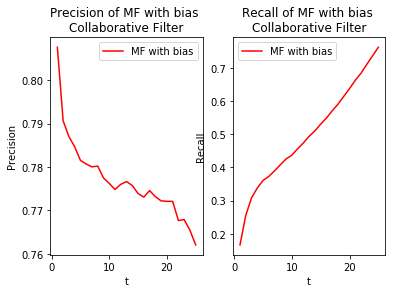

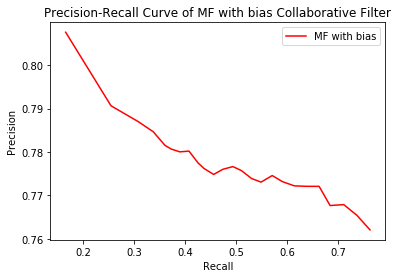

In [21]:
plt.subplot(1,2,1)
plt.plot(np.arange(1,26), mf_prec, 'r', label='MF with bias')
plt.title('Precision of MF with bias \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,26), mf_rec, 'r', label='MF with bias')
plt.title('Recall of MF with bias \nCollaborative Filter')
plt.xlabel('t')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(mf_rec, mf_prec, 'r', label='MF with bias')
plt.title('Precision-Recall Curve of MF with bias Collaborative Filter')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### QUESTION 39

In [19]:
plt.plot(nmf_rec, nmf_prec, 'r', label='k-NN')
plt.plot(nnmf_rec, nnmf_prec, 'b', label='NNMF')
plt.plot(mf_rec, mf_prec, 'g', label='MF with bias')
plt.title('Precision-Recall Curve of Different Collaborative Filters')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

NameError: name 'nmf_rec' is not defined